In [1]:
scores = '../out/ko_scores.txt'
bscores = '../out/ko_scores_rep.txt'

In [2]:
# plotting imports
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('white')

plt.rc('font', size=11)
plt.rc('xtick', labelsize=11)
plt.rc('ytick', labelsize=11)
plt.rc('axes', labelsize=12, titlesize=12)
plt.rc('legend', fontsize=11)

In [3]:
# other imports
import itertools
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm

/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Significant changes between strains
---

In [10]:
def get_variance_function(v,
                          slices=10,
                          min_periods=20,
                          sample=None,
                          function=pd.Series.var):
    x = []
    y = []
    z = []
    vmin = v['sum'].min()
    vmax = v['sum'].max()
    lv = None
    for rv in np.linspace(vmin, vmax, slices):
        if lv is None:
            lv = rv
            continue
        vs = v[(v['sum'] >= lv) & (v['sum'] <= rv)]
        if vs.shape[0] < min_periods:
            lv = rv
            continue
        if sample is not None:
            var = function(vs['sub'].sample(sample,
                                            replace=True))
            mean = vs['sub'].sample(sample,
                                    replace=True).mean()
        else:
            var = function(vs['sub'])
            mean = vs['sub'].mean()
        x.append((lv + rv) / 2)
        y.append(var)
        z.append(mean)
    return x, y, z

def get_null(m):
    b1 = m.loc['B1']
    b2 = m.loc['B2']
    cdx = []
    for c in {x[0]
              for x in b1.index}.intersection({x[0]
                                               for x in b2.index}):
        m1 = b1.loc[c]
        m2 = b2.loc[c]
        c1 = set(m1.index)
        c2 = set(m2.index)
        idx = sorted(c1.intersection(c2))
        a1 = m1.loc[idx]['score']
        a2 = m2.loc[idx]['score']
        if len(idx) > 10:
            r, p = stats.pearsonr(a1, a2)
            if r >= 0.5:
                cdx.append(c)
    c1 = set(b1.index)
    c2 = set(b2.index)
    idx = sorted(c1.intersection(c2))
    mdx = [x for x in idx
           if x[0] not in cdx]
    a1 = b1.loc[mdx]['score']
    a2 = b2.loc[mdx]['score']
    a1.name = 'batch1'
    a2.name = 'batch2/3'
    v1 = (a1 + a2)
    v2 = abs(a1 - a2)
    v1.name = 'sum'
    v2.name = 'sub'
    v = a1.to_frame().join(a2.to_frame())
    v = v.join(v1.to_frame()).join(v2.to_frame())
    x, y, z = get_variance_function(v, 100,
                                    function=pd.Series.std)
    return x, y, z

bm = pd.read_table(bscores, index_col=[3, 1, 0, 2, 5])
x, y, z = get_null(bm)

In [11]:
def get_deviating_scores(m, s1, s2, x, y, z):
    a1 = m[s1]
    a2 = m[s2]
    v1 = (a1 + a2)
    v2 = abs(a1 - a2)
    v1.name = 'sum'
    v2.name = 'sub'
    w = a1.to_frame().join(a2.to_frame())
    w = w.join(v1.to_frame()).join(v2.to_frame())
    w['var'] = np.interp((a1 + a2),
                         x,
                         y)
    w['mean'] = np.interp((a1 + a2),
                     x,
                     z)
    w['pval'] = [1 - stats.norm.cdf(x, loc=z, scale=y)
                 for x,y,z in w[['sub', 'var', 'mean']].values]
    w['qval'] = sm.stats.multipletests(w['pval'], method='fdr_bh')[1]
    return w

In [54]:
m = pd.read_table(scores, index_col=[0, 1, 2])
m = m[~m.index.duplicated()].dropna()
m['phenotype'] = m['qvalue'] <= 0.05

In [44]:
ps = {}
pc = {}
pp = {}
p = pd.read_table(scores, index_col=[0, 1, 2])
for s in {x[0] for x in p.index}:
    v = p.loc[s]
    v = v[~v.index.duplicated()].dropna()
    v['phenotype'] = [1 if x < 0 and y <= 0.05
                      else 0
                      for x,y in v[['score', 'qvalue']].values]
    ps[s] = (v['phenotype'].sum(), v['phenotype'].sum() / v.shape[0])
    pc[s] = {}
    pp[s] = {}
    for c, value in v.groupby('condition').sum()['phenotype'].items():
        pc[s][c] = value
    for c, value in (v.groupby('condition').sum()['phenotype'] /
                     v.groupby('condition').count()['phenotype']).items():
        pp[s][c] = value

In [58]:
# plt.figure(figsize=(7, 3))

res = []
res1 = []
res2 = []
for s1, s2 in itertools.combinations({x[0] for x in m.index}, 2):
    s = s1 + '/' + s2
    m1 = m.loc[s1]['score']
    m1 = m1[~m1.index.duplicated()].dropna()
    m2 = m.loc[s2]['score']
    m2 = m2[~m2.index.duplicated()].dropna()
    m1.name = s1
    m2.name = s2
    d = m1.to_frame().join(m2.to_frame(), how='inner').dropna()
    w = get_deviating_scores(d, s1, s2, x, y, z)
    v = w.groupby('gene').min()
#     d['delta'] = abs(d[s1] - d[s2])
#     d['diff'] = d['delta'] >= 4
#     t = d.groupby('condition').sum()['diff']
    w['diff'] = w['qval'] < 1E-2
    u = w.groupby('condition').sum()['diff']
    swap = m[m['phenotype'] == 1].loc[
            ([s1, s2]),
            ].reset_index().set_index(
            ['condition', 'gene']
            ).loc[w[w['qval'] < 1E-2].index].dropna().shape[0]
#     sns.kdeplot(data=d['delta'],
#                 label=s)
    res.append((s,
                ps[s1][0], ps[s2][0],
                ps[s1][1], ps[s2][1],
#                 d[d['delta'] >= 4].shape[0] / d.shape[0],
#                 d[d['delta'] >= 4].shape[0],
#                 d.shape[0],
                w[w['qval'] <= 1E-2].shape[0] / w.shape[0],
                w[w['qval'] <= 1E-2].shape[0],
                swap / w.shape[0],
                swap,
                w.shape[0],
                v[v['qval'] <= 1E-2].shape[0] / v.shape[0]))
#     for c, v in t.items():
#         res1.append((s, c, pc[s1][c], pc[s2][c], v))
    for c, v in u.items():
        res2.append((s, c, pc[s1][c], pc[s2][c], v))

r = pd.DataFrame(res,
                 columns=['strains',
                          'pheno1',
                          'pheno2',
                          'pheno-proportion1',
                          'pheno-proportion2',
#                           'proportion',
#                           'different',
#                           'total',
                          'proportion',
                          'different',
                          'swap-proportion',
                          'swap-different',
                          'total',
                          'gene-prop'])
# r1 = pd.DataFrame(res1,
#                   columns=['strains',
#                            'condition',
#                            'pheno1', 'pheno2',
#                            'different'])
r2 = pd.DataFrame(res2,
                  columns=['strains',
                           'condition',
                           'pheno1', 'pheno2',
                           'different'])

In [59]:
r.sort_values('swap-proportion')

,strains,pheno1,pheno2,pheno-proportion1,pheno-proportion2,proportion,different,swap-proportion,swap-different,total,gene-prop
4,Y55/UWOP,1809,1867,0.014552,0.015478,0.003691,417,0.003195,361,112980,0.083307
5,YPS/UWOP,2646,1867,0.020985,0.015478,0.006868,780,0.005723,650,113577,0.146798
3,Y55/YPS,1809,2646,0.014552,0.020985,0.008071,935,0.007043,816,115854,0.172871
2,S288C/UWOP,4393,1867,0.029021,0.015478,0.008089,949,0.007373,865,117323,0.172676
0,S288C/Y55,4393,1809,0.029021,0.014552,0.008292,1007,0.007469,907,121438,0.181212
1,S288C/YPS,4393,2646,0.029021,0.020985,0.011098,1364,0.009544,1173,122905,0.228908


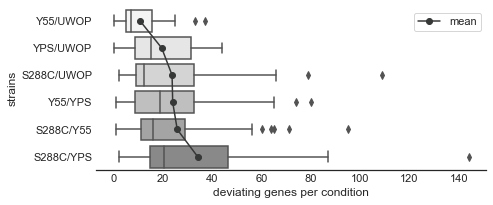

In [61]:
plt.figure(figsize=(7, 3))

sns.boxplot(data=r2,
            x='different',
            y='strains',
            order=r2.groupby('strains').mean()['different'].sort_values().index,
            palette=sns.color_palette('Greys', 10))
plt.plot([r2[r2['strains'] == s].mean()['different']
          for s in r2.groupby('strains').mean()['different'].sort_values().index],
         range(len(set(r2['strains']))),
         'o-',
         color=sns.xkcd_rgb['dark grey'],
         label='mean')
plt.legend(frameon=True)
plt.xlabel('deviating genes per condition')
sns.despine(left=True);

Differences in the number of phenotypes
---

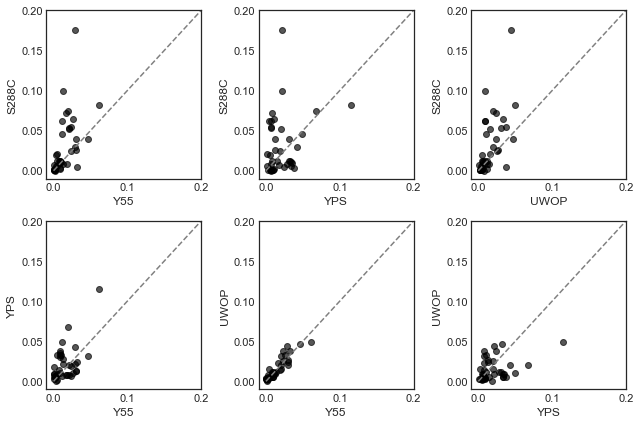

In [62]:
plt.figure(figsize=(9, 6))

conds = {y for x in pp
         for y in pp[x]}

i = 1
for s1, s2 in itertools.combinations(ps, 2):
    plt.subplot(2, 3, i)
    
    if s1 == 'S288C':
        tmp = s2
        s2 = s1
        s1 = tmp
    
    plt.plot([pp[s1].get(x, np.nan) for x in conds],
             [pp[s2].get(x, np.nan) for x in conds],
             'ko',
             alpha=0.66)
    
    plt.xlabel(s1)
    plt.ylabel(s2)
    
    plt.plot([0, 0.2],
             [0, 0.2],
             '--',
             color='grey')
    
    plt.xlim(-0.01, 0.20)
    plt.ylim(-0.01, 0.20)
        
    i += 1

plt.tight_layout()

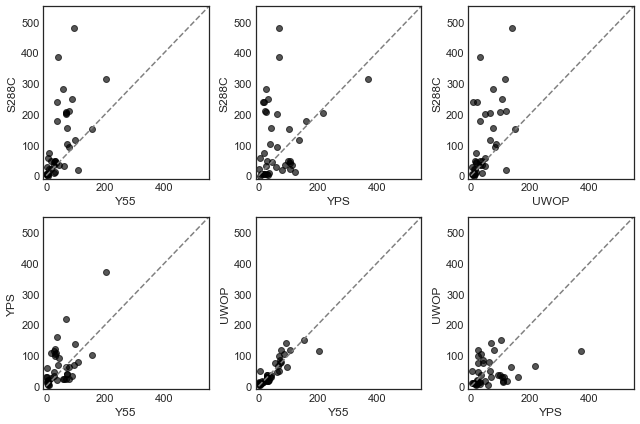

In [63]:
plt.figure(figsize=(9, 6))

conds = {y for x in pp
         for y in pp[x]}

i = 1
for s1, s2 in itertools.combinations(ps, 2):
    plt.subplot(2, 3, i)
    
    if s1 == 'S288C':
        tmp = s2
        s2 = s1
        s1 = tmp
    
    plt.plot([pc[s1].get(x, np.nan) for x in conds],
             [pc[s2].get(x, np.nan) for x in conds],
             'ko',
             alpha=0.66)
    
    plt.xlabel(s1)
    plt.ylabel(s2)
    
    plt.plot([0, 550],
             [0, 550],
             '--',
             color='grey')
    
    plt.xlim(-10, 550)
    plt.ylim(-10, 550)
        
    i += 1

plt.tight_layout()

In [64]:
pd.DataFrame(pp).sort_values('S288C', ascending=False)

,S288C,UWOP,Y55,YPS
Caffeine 15mM (48H),0.175137,0.043835,0.028407,0.021342
Cadmium chloride (48H),0.099174,0.009142,0.012387,0.021336
Caspofungin (72H),0.081558,0.049372,0.061348,0.114790
Acetic acid (48H),0.074954,0.020498,0.019970,0.067141
Glycerol 2% (48H),0.072572,0.023359,0.016924,0.007738
Maltose 2% (48H),0.064566,0.033417,0.025982,0.010220
Maltose 2% (72H),0.061483,0.008538,NaN,0.004645
Glycerol 2% (72H),0.061467,0.008666,0.011182,0.006852
6-AU + 39ºC (72H),0.053977,0.037516,0.023263,0.007112
6-AU + 39ºC (48H),0.053461,0.031211,0.020544,0.007421


<h5><a href="javascript:toggle()" target="_self">toggle source code</a></h5>